In [1]:
import pandas as pd
import numpy as np
import cpa
import scanpy as sc
from sklearn.metrics import r2_score
import anndata
import nbimporter
import itertools


Global seed set to 0


In [ ]:
# import generate_nlp

In [ ]:
help(cpa.CPA.setup_anndata)

In [3]:
# adata_obs_meta  = pd.read_csv("data/adata_obs_meta.csv")
da = pd.read_parquet('data/de_train.parquet')

### 考虑先提取药物特征，再创建adata对象

### 创建NLP 特征
调用generate_nlp 函数

In [4]:
drug_smile = np.unique(da.SMILES)
len(drug_smile)

146

In [5]:
from nlp import generate_nlp
drug_smile = np.unique(da.SMILES)
# Create an empty dataframe
stat_smile = pd.DataFrame()

# Convert the list to a pandas Series
drug_series = pd.Series(drug_smile)

# Apply the generate_nlp function to each element and store the result in the dataframe
stat_smile = drug_series.apply(generate_nlp).reset_index(drop=True)
stat_smile['SMILES'] = drug_series
stat_smile.shape

(146, 21)

### 将stat_smile与da进行拼接

In [6]:
da_smile = pd.merge(da, stat_smile, on='SMILES', how='inner')

cell_features = ['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control']
cell_features = list(set(stat_smile.columns.tolist() + cell_features))
gene_features = [col for col in da.columns if col not in cell_features]

In [28]:
cols_to_drop = [da_smile.sm_lincs_id.name, da_smile.SMILES.name]
cell_features_data = da_smile[cell_features].drop(columns=cols_to_drop)
gene_features_data = da_smile[gene_features]
gene_names = pd.Series(da.columns[5:])

means = gene_features_data.mean()  # Calculate mean of each column
variances = gene_features_data.var(ddof=0)  # Calculate variance of each column

# Create a new DataFrame with means and variances
gene_stats_df = pd.DataFrame({
    'Mean': means,
    'Variance': variances
})


print(cell_features_data.shape)
print(gene_features_data.shape)
print(gene_names.shape)
print(gene_stats_df.shape)

(614, 23)
(614, 18211)
(18211,)
(18211, 2)


### 计算每个基因的统计学特征 后写入adata

### 检查缺失值

In [30]:

# Function to check for missing values in a DataFrame
def check_missing_values(df):
    # Check if there's any missing value in the DataFrame
    missing_values = df.isnull().values.any()
    return missing_values

# Example usage of the function
has_missing_values = check_missing_values(gene_features_data)
print(f"The DataFrame has missing values: {has_missing_values}")

has_missing_values = check_missing_values(cell_features_data)
print(f"The DataFrame has missing values: {has_missing_values}")

has_missing_values = check_missing_values(gene_stats_df)
print(f"The DataFrame has missing values: {has_missing_values}")

The DataFrame has missing values: False
The DataFrame has missing values: False
The DataFrame has missing values: False


In [39]:
adata = anndata.AnnData(X=gene_features_data)
#adata.obs = pd.DataFrame(cell_features_data, index=[f"Cell_{i}" for i in range(cell_features_data.shape[0])])

adata.obs = cell_features_data

# adata.var = pd.DataFrame(index=gene_stats_df)
adata.var.index = gene_stats_df.index
adata.var = gene_stats_df
adata.layers['counts'] = gene_features_data

In [41]:
import pandas as pd
from scipy import sparse

# Function to check for missing values in an AnnData object
def check_missing_values_in_anndata(adata):
    missing_values = {}
    # Check for missing values in .obs (observations/cell features)
    missing_values['obs'] = adata.obs.isnull().values.any()
    # Check for missing values in .var (variables/gene features)
    missing_values['var'] = adata.var.isnull().values.any()
    # Check for missing values in .X (data matrix)
    if sparse.issparse(adata.X):  # Handling the case of a sparse matrix
        missing_values['X'] = sparse.isnan(adata.X.data).any()
    else:  # Handling the case of a dense matrix
        missing_values['X'] = pd.DataFrame(adata.X).isnull().values.any()
    

    return missing_values

# Use the function to check the adata object
missing_values_report = check_missing_values_in_anndata(adata)
print(missing_values_report)



{'obs': False, 'var': False, 'X': False}


In [42]:
# Function to find missing values in the .obs attribute of an AnnData object
def find_missing_values_in_obs(adata):
    # Create a DataFrame to store the missing value information
    missing_info = pd.DataFrame()
    
    # Find the columns with missing values
    columns_with_missing = adata.obs.columns[adata.obs.isnull().any()].tolist()
    
    # For each column with missing data, find the rows with missing values
    for col in columns_with_missing:
        missing_info[col] = adata.obs[col].isnull()
    
    # Filter the .obs DataFrame to only include rows with any missing values
    rows_with_missing = adata.obs[adata.obs.isnull().any(axis=1)]
    
    return rows_with_missing, missing_info

# Use the function to find the missing values
rows_with_missing, missing_info = find_missing_values_in_obs(adata)

print("Rows with missing values:")
print(rows_with_missing)

print("\nMissing values information:")
print(missing_info)


Rows with missing values:
Empty DataFrame
Columns: [max_consecutive_C, sm_name, count_c, cell_type, count_open_bracket, count_n, count_close_bracket, total_chars, count_C, count_1, count_N, count_equal, count_close_s_bracket, count_H, count_O, num_rings, num_substructures, count_2, count_F, chars_in_bracket, count_open_s_bracket, control, count_a]
Index: []

[0 rows x 23 columns]

Missing values information:
Empty DataFrame
Columns: []
Index: []


In [43]:
adata

AnnData object with n_obs × n_vars = 614 × 18211
    obs: 'max_consecutive_C', 'sm_name', 'count_c', 'cell_type', 'count_open_bracket', 'count_n', 'count_close_bracket', 'total_chars', 'count_C', 'count_1', 'count_N', 'count_equal', 'count_close_s_bracket', 'count_H', 'count_O', 'num_rings', 'num_substructures', 'count_2', 'count_F', 'chars_in_bracket', 'count_open_s_bracket', 'control', 'count_a'
    var: 'Mean', 'Variance'
    layers: 'counts'

In [44]:
perturbation_key = 'sm_name'
dosage_key = 'dosage'  # You should set this to the correct dosage key if it exists.
category_key = 'category'  # Name for the new category column

# List of columns to concatenate to create the category
keys = [perturbation_key, dosage_key]

# If dosage_key is not in adata.obs, we add it with a default value of '1.0'
if dosage_key not in adata.obs.columns:
    adata.obs[dosage_key] = '1.0'  # Default dosage

adata.obs[category_key] = adata.obs[keys].apply(lambda x: "_".join(str(item) if item == item else "" for item in x), axis=1)

In [45]:

# Proceed with CPA setup
cpa.CPA.setup_anndata(adata,
                      perturbation_key=perturbation_key,
                      control_group='control',
                      dosage_key=dosage_key,
                      batch_key=None,
                      is_count_data=True,
                      categorical_covariate_keys=['cell_type'],
                      max_comb_len=2,)

100%|████████████████████████████████████████████████████████████████████████████| 614/614 [00:00<00:00, 306620.15it/s]


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [46]:
ae_hparams = {
    "n_latent": 128,
    "recon_loss": "nb",
    "doser_type": "logsigm",
    "n_hidden_encoder": 512,
    "n_layers_encoder": 3,
    "n_hidden_decoder": 512,
    "n_layers_decoder": 3,
    "use_batch_norm_encoder": True,
    "use_layer_norm_encoder": False,
    "use_batch_norm_decoder": True,
    "use_layer_norm_decoder": False,
    "dropout_rate_encoder": 0.1,
    "dropout_rate_decoder": 0.1,
    "variational": False,
    "seed": 434,
}

trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_pretrain_ae": 30,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 3,
    "mixup_alpha": 0.1,
    "adv_steps": 2,
    "n_hidden_adv": 64,
    "n_layers_adv": 2,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "reg_adv": 20.0,
    "pen_adv": 20.0,
    "lr": 0.0003,
    "wd": 4e-07,
    "adv_lr": 0.0003,
    "adv_wd": 4e-07,
    "adv_loss": "cce",
    "doser_lr": 0.0003,
    "doser_wd": 4e-07,
    "do_clip_grad": False,
    "gradient_clip_value": 1.0,
    "step_size_lr": 45,
}

In [47]:
model = cpa.CPA(adata=adata,
                # split_key='split_1ct_MEC',
                # train_split='train',
                # valid_split='valid',
                # test_split='ood',
                **ae_hparams,
               )

Global seed set to 434


In [48]:
import os
current_directory = os.getcwd()

model.train(max_epochs=10,  # 2000
            use_gpu=False,
            batch_size=128,
            plan_kwargs=trainer_params,
            early_stopping_patience=10,
            check_val_every_n_epoch=5,
            save_path=current_directory,
           )


100%|███████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 775.69it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/10:  40%|▍| 4/10 [00:42<01:04, 10.76s/it, v_num=1, recon=nan, r2_mean=nan, adv_loss=nan, acc_pert=0.0111, acc_c

ValueError: Input X contains NaN.
NearestNeighbors does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Epoch 5/2000:   0%| | 4/2000 [05:32<46:02:47, 83.05s/it, v_num=1, recon=nan, r2_mean=nan, adv_loss=nan, acc_pert=0.0111


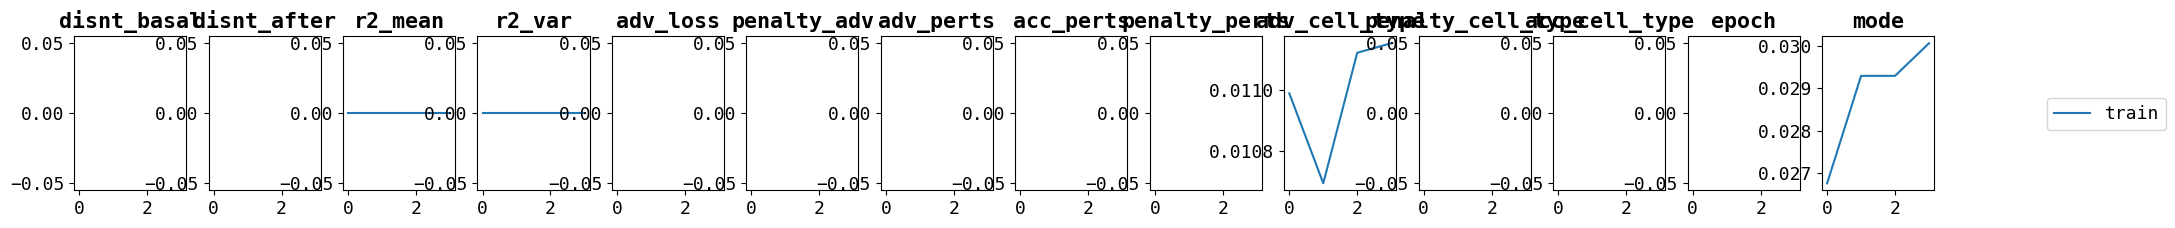

In [15]:
cpa.pl.plot_history(model)

In [50]:
prediction = model.predict(adata, batch_size=1024)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


### create gene info

In [52]:
from Bio import Entrez

def get_gene_info(gene_name):
    Entrez.email = "bchen342@wisc.edu"  # Replace with your email address
    search_result = Entrez.esearch(db="gene", term=gene_name, retmax=10)
    record = Entrez.read(search_result)
    if record["IdList"]:
        gene_id = record["IdList"][0]
        gene_summary = Entrez.esummary(db="gene", id=gene_id)
        summary = Entrez.read(gene_summary, validate=False)  # Set validate to False here
        return summary
    else:
        return "No gene found for this name."


# Example usage:
gene_info = get_gene_info("A1BG")
